# PREDICCIONES

## 1.PREPARACIÓN Y FUTURE ENGINEERING

In [1]:
#!pip install pandas
#!pip install pandas numpy scikit-learn xgboost matplotlib seaborn tensorflow
#!pip install scikit-learn
#!pip install xgboost
#!pip install matplotlib
#!pip install seaborn


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("valencia_clima_unificado (2).csv", delimiter=';', on_bad_lines='skip')


In [4]:
# Convertir la columna de fecha
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)

# Extraer características temporales
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['weekday'] = df['datetime'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)


In [5]:
# Crear columnas desplazadas a 30 días
df['temp_futuro_30'] = df['temp'].shift(-30)
df['precip_futuro_30'] = df['precip'].shift(-30)
df['humidity_futuro_30'] = df['humidity'].shift(-30)
df['uvindex_futuro_30'] = df['uvindex'].shift(-30)


In [6]:
# Crear lags de 1, 2, 3 y 7 días para temp, precip y humidity
lags = [1, 2, 3, 7]
for l in lags:
    df[f'temp_lag_{l}'] = df['temp'].shift(l)
    df[f'precip_lag_{l}'] = df['precip'].shift(l)
    df[f'humidity_lag_{l}'] = df['humidity'].shift(l)


In [7]:
df_model = df.dropna(subset=[
    'temp_futuro_30', 'precip_futuro_30', 'humidity_futuro_30', 'uvindex_futuro_30',
    'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_7',
    'precip_lag_1', 'precip_lag_2', 'precip_lag_3', 'precip_lag_7',
    'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_7'
])


In [8]:
df_train = df_model[df_model['year'] <= 2024]
df_test = df_model[df_model['year'] == 2025]

print("Entrenamiento:", len(df_train), " | Test:", len(df_test))


Entrenamiento: 2480  | Test: 44


In [9]:
features = [col for col in df_model.columns if 'lag' in col or col in ['day', 'month', 'year', 'weekday', 'is_weekend']]
target = 'temp_futuro_30'


## 2. Modelos y entrenamiento

---------------------------------------------------------------------------------------------------
## *MODELOS DE REGRESIÓN*


### EVALUACIÓN DE LOS MODELOS

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

def evaluar_modelo(nombre, modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    print(f"\n📊 Resultados para: {nombre}")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2:", r2_score(y_test, y_pred))
    return y_pred


 ##### 1. Regresión lineal 

In [11]:

from sklearn.linear_model import LinearRegression

modelo_lr = LinearRegression()
_ = evaluar_modelo("Regresión Lineal Múltiple", modelo_lr, df_train[features], df_train[target], df_test[features], df_test[target])




📊 Resultados para: Regresión Lineal Múltiple
MAE: 3.5354199835473654
RMSE: 4.409745879994403
R2: -4.972908491649686


##### 2. Random Forest Regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor

modelo_rf = RandomForestRegressor(n_estimators=50, random_state=42)
_ = evaluar_modelo("Random Forest", modelo_rf, df_train[features], df_train[target], df_test[features], df_test[target])




📊 Resultados para: Random Forest
MAE: 1.7593181818181811
RMSE: 2.0791838652352377
R2: -0.32783627072230725


##### 3. XGBoost Regressor

In [13]:
from xgboost import XGBRegressor

modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
_ = evaluar_modelo("XGBoost", modelo_xgb, df_train[features], df_train[target], df_test[features], df_test[target])



📊 Resultados para: XGBoost
MAE: 1.6655445228923453
RMSE: 2.109637233679819
R2: -0.36701820611517233


##### 4.SVR (Support Vector Regression)

In [14]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train[features])
X_test_scaled = scaler.transform(df_test[features])

modelo_svr = SVR()
_ = evaluar_modelo("SVR", modelo_svr, X_train_scaled, df_train[target], X_test_scaled, df_test[target])




📊 Resultados para: SVR
MAE: 2.295120403059779
RMSE: 2.9498982022843308
R2: -1.672838961482546


##### 5. MLPRegressor (Red neuronal con Keras)

In [15]:
from sklearn.neural_network import MLPRegressor

modelo_mlp = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
_ = evaluar_modelo("MLPRegressor", modelo_mlp, X_train_scaled, df_train[target], X_test_scaled, df_test[target])





📊 Resultados para: MLPRegressor
MAE: 1.499509636242883
RMSE: 1.8127705639028215
R2: -0.009356108639636984


C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


---------------------------------------------------------------------------------------------------------

## *Modelos Multi-output*

### EVALUACIÓN DE LOS MODELOS

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

def evaluar_multioutput(nombre_modelo, y_true, y_pred, columnas):
    print(f"\n📊 Evaluación para: {nombre_modelo}")
    resultados = []

    for i, col in enumerate(columnas):
        mae = mean_absolute_error(y_true[col], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_true[col], y_pred[:, i]))
        r2 = r2_score(y_true[col], y_pred[:, i])
        resultados.append([col, mae, rmse, r2])

    df_resultados = pd.DataFrame(resultados, columns=["Variable", "MAE", "RMSE", "R2"])
    print(df_resultados)
    return df_resultados

def evaluar_univariable(nombre_modelo, y_true, y_pred):
    print(f"\n📊 Evaluación para: {nombre_modelo}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R2:", r2_score(y_true, y_pred))


In [17]:
targets = ['temp_futuro_30', 'precip_futuro_30', 'humidity_futuro_30', 'uvindex_futuro_30']


##### 1. Random Forest Regressor multioutput

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

rf_multi = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, random_state=42))
rf_multi.fit(df_train[features], df_train[targets])
y_pred_rf = rf_multi.predict(df_test[features])

_ = evaluar_multioutput("RandomForest MultiOutput", df_test[targets], y_pred_rf, targets)



📊 Evaluación para: RandomForest MultiOutput
             Variable        MAE       RMSE        R2
0      temp_futuro_30   1.759318   2.079184 -0.327836
1    precip_futuro_30   1.881991   2.863183 -0.205367
2  humidity_futuro_30  13.789182  17.234112 -1.485086
3   uvindex_futuro_30   1.436818   2.054209 -0.548423


##### 2. XGBoost una por variable 

In [19]:
from xgboost import XGBRegressor
import numpy as np

predicciones_xgb = {}

for target_col in targets:
    modelo = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    modelo.fit(df_train[features], df_train[target_col])
    predicciones_xgb[target_col] = modelo.predict(df_test[features])


y_pred_xgb = np.column_stack([predicciones_xgb[col] for col in targets])
_ = evaluar_multioutput("XGBoost por variable", df_test[targets], y_pred_xgb, targets)



📊 Evaluación para: XGBoost por variable
             Variable        MAE       RMSE        R2
0      temp_futuro_30   1.665545   2.109637 -0.367018
1    precip_futuro_30   1.763346   2.819444 -0.168822
2  humidity_futuro_30  14.953083  18.910359 -1.992010
3   uvindex_futuro_30   1.485124   2.159457 -0.711156


##### 3. MLPRegressor multi-output

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train[features])
X_test_scaled = scaler.transform(df_test[features])

# Crear el modelo con early stopping
mlp_multi = MLPRegressor(hidden_layer_sizes=(100, 50),
                         max_iter=1000,
                         early_stopping=True,
                         random_state=42)

# Entrenar el modelo
mlp_multi.fit(X_train_scaled, df_train[targets])

# Predecir en el conjunto de test
y_pred_mlp = mlp_multi.predict(X_test_scaled)


# Evaluar
_ = evaluar_multioutput("MLPRegressor MultiOutput", df_test[targets], y_pred_mlp, targets)




📊 Evaluación para: MLPRegressor MultiOutput
             Variable        MAE       RMSE        R2
0      temp_futuro_30   3.640236   4.532027 -5.308755
1    precip_futuro_30   1.958868   3.125854 -0.436675
2  humidity_futuro_30  14.685697  18.333571 -1.812274
3   uvindex_futuro_30   2.546269   3.092132 -2.508461


##### 4.SVR con GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}
grid_svr = GridSearchCV(SVR(), param_grid, cv=3)
grid_svr.fit(X_train_scaled, df_train['temp_futuro_30'])
y_pred_svr = grid_svr.predict(X_test_scaled)

evaluar_univariable("SVR con GridSearchCV (temp)", df_test['temp_futuro_30'], y_pred_svr)




📊 Evaluación para: SVR con GridSearchCV (temp)
MAE: 1.7644445791822911
RMSE: 2.155913272412918
R2: -0.42764854551406883


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Variables objetivo
targets = ['temp_futuro_30', 'precip_futuro_30', 'humidity_futuro_30', 'uvindex_futuro_30']

# Parámetros para GridSearch
param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}

# Guardar resultados
resultados_svr = []

for target in targets:
    print(f"\nEntrenando SVR para: {target}")
    grid_svr = GridSearchCV(SVR(), param_grid, cv=3)
    grid_svr.fit(X_train_scaled, df_train[target])
    y_pred = grid_svr.predict(X_test_scaled)

    # Evaluación
    mae = mean_absolute_error(df_test[target], y_pred)
    rmse = np.sqrt(mean_squared_error(df_test[target], y_pred))
    r2 = r2_score(df_test[target], y_pred)

    resultados_svr.append([target, mae, rmse, r2])

# Mostrar tabla resumen
df_resultados_svr = pd.DataFrame(resultados_svr, columns=["Variable", "MAE", "RMSE", "R2"])
print("\n📊 Resultados globales SVR:")
print(df_resultados_svr)



Entrenando SVR para: temp_futuro_30

Entrenando SVR para: precip_futuro_30

Entrenando SVR para: humidity_futuro_30

Entrenando SVR para: uvindex_futuro_30

📊 Resultados globales SVR:
             Variable        MAE       RMSE        R2
0      temp_futuro_30   1.764445   2.155913 -0.427649
1    precip_futuro_30   1.555829   2.614270 -0.004898
2  humidity_futuro_30  11.576758  14.267103 -0.703080
3   uvindex_futuro_30   2.237149   2.745896 -1.766743


---------------------------------------------------------------------
## *Modelos de Clasificación*

#### ✅ Paso 1: Crear variable objetivo binaria

In [23]:

# Crear la columna binaria directamente en df
df.loc[:, 'llovera_en_30_dias'] = (df['precip_futuro_30'] > 0).astype(int)

# Volver a construir df_model con todas las columnas necesarias (incluyendo la nueva)
df_model = df.dropna(subset=[
    'temp_futuro_30', 'precip_futuro_30', 'humidity_futuro_30', 'uvindex_futuro_30',
    'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_7',
    'precip_lag_1', 'precip_lag_2', 'precip_lag_3', 'precip_lag_7',
    'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_7',
    'llovera_en_30_dias'
])

# Volver a dividir los datos
df_train = df_model[df_model['year'] <= 2024]
df_test = df_model[df_model['year'] == 2025]

# Targets y features escalados ya están hechos, ahora podemos hacer:
X_train_clf = X_train_scaled
X_test_clf = X_test_scaled
y_train_clf = df_train['llovera_en_30_dias']
y_test_clf = df_test['llovera_en_30_dias']


#### ✅ Paso 2: Evaluación común para clasificación

In [24]:
def evaluar_clasificacion(nombre_modelo, y_true, y_pred):
    print(f"\n📊 Evaluación para: {nombre_modelo}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred))
    print("Reporte completo:\n", classification_report(y_true, y_pred))

#### ✅ Paso 3: Entrenamiento de modelos

##### 1. Logisitc Regression

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_clf, y_train_clf)
y_pred_log = logreg.predict(X_test_clf)
evaluar_clasificacion("Logistic Regression", y_test_clf, y_pred_log)



📊 Evaluación para: Logistic Regression
Accuracy: 0.6136363636363636
F1-score: 0.0
Matriz de confusión:
 [[27  0]
 [17  0]]
Reporte completo:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76        27
           1       0.00      0.00      0.00        17

    accuracy                           0.61        44
   macro avg       0.31      0.50      0.38        44
weighted avg       0.38      0.61      0.47        44



C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

##### 2. Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)
y_pred_rf_clf = rf_clf.predict(X_test_clf)
evaluar_clasificacion("Random Forest Classifier", y_test_clf, y_pred_rf_clf)


📊 Evaluación para: Random Forest Classifier
Accuracy: 0.6136363636363636
F1-score: 0.0
Matriz de confusión:
 [[27  0]
 [17  0]]
Reporte completo:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76        27
           1       0.00      0.00      0.00        17

    accuracy                           0.61        44
   macro avg       0.31      0.50      0.38        44
weighted avg       0.38      0.61      0.47        44



C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

##### 3.XGBoost Forest Classifier

In [27]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_clf, y_train_clf)
y_pred_xgb = xgb_clf.predict(X_test_clf)
evaluar_clasificacion("XGBoost Classifier", y_test_clf, y_pred_xgb)

C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:17:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Evaluación para: XGBoost Classifier
Accuracy: 0.6136363636363636
F1-score: 0.0
Matriz de confusión:
 [[27  0]
 [17  0]]
Reporte completo:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76        27
           1       0.00      0.00      0.00        17

    accuracy                           0.61        44
   macro avg       0.31      0.50      0.38        44
weighted avg       0.38      0.61      0.47        44



C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

##### 4.MLPClassifier

In [28]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, early_stopping=True, random_state=42)
mlp_clf.fit(X_train_clf, y_train_clf)
y_pred_mlp_clf = mlp_clf.predict(X_test_clf)
evaluar_clasificacion("MLPClassifier", y_test_clf, y_pred_mlp_clf)



📊 Evaluación para: MLPClassifier
Accuracy: 0.6136363636363636
F1-score: 0.0
Matriz de confusión:
 [[27  0]
 [17  0]]
Reporte completo:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76        27
           1       0.00      0.00      0.00        17

    accuracy                           0.61        44
   macro avg       0.31      0.50      0.38        44
weighted avg       0.38      0.61      0.47        44



C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Elena Chirivella\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

---------------------------------------------------------------------------------------------------------------
## *Modelos de series temporales* - EN GOOGLE COLLAB

----------------------------------------------------------------------------------------------------------------------------------
## 3.ELECCION DE MODELOS - GRÁFICAS

C:\Users\Elena Chirivella\AppData\Local\Temp\ipykernel_20060\1010432036.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_temp, x="MAE", y="Modelo", palette="crest")


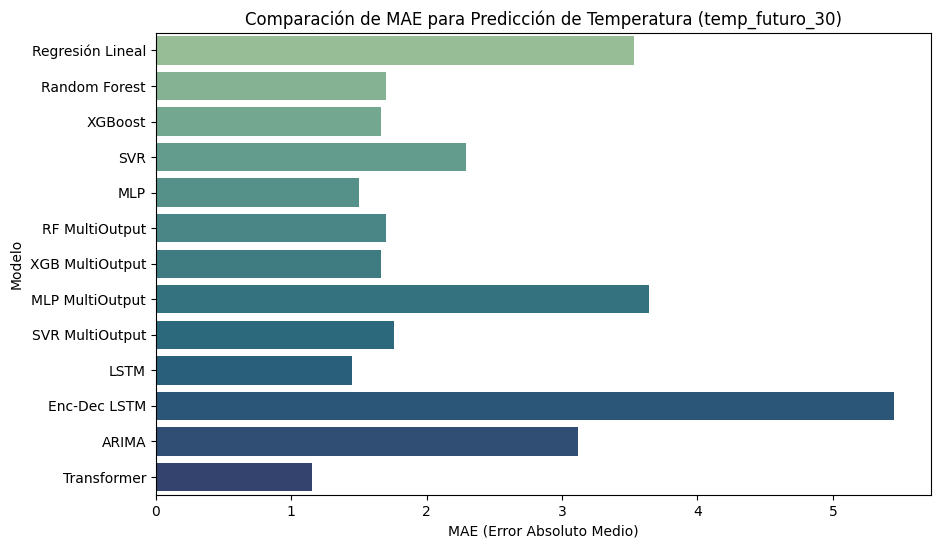

C:\Users\Elena Chirivella\AppData\Local\Temp\ipykernel_20060\1010432036.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_temp, x="RMSE", y="Modelo", palette="flare")


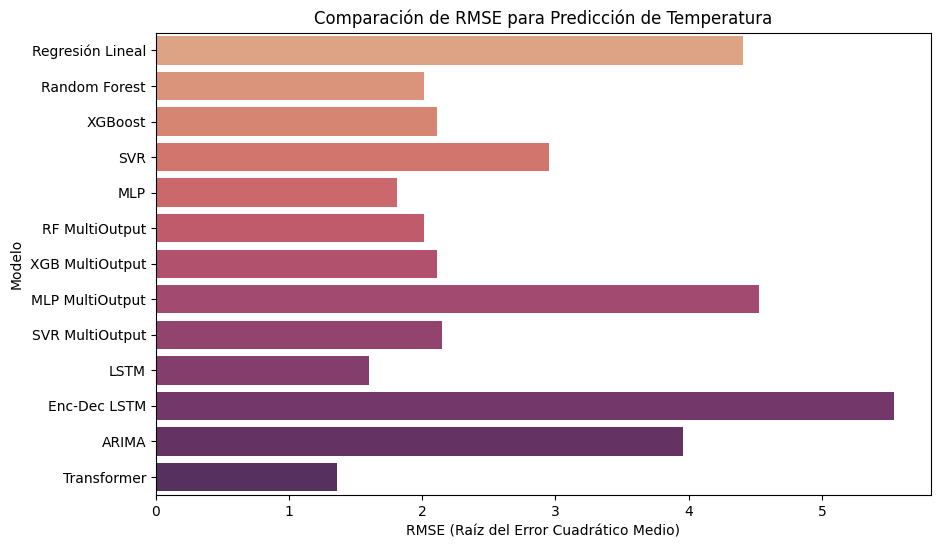

C:\Users\Elena Chirivella\AppData\Local\Temp\ipykernel_20060\1010432036.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_temp, x="R2", y="Modelo", palette="coolwarm")


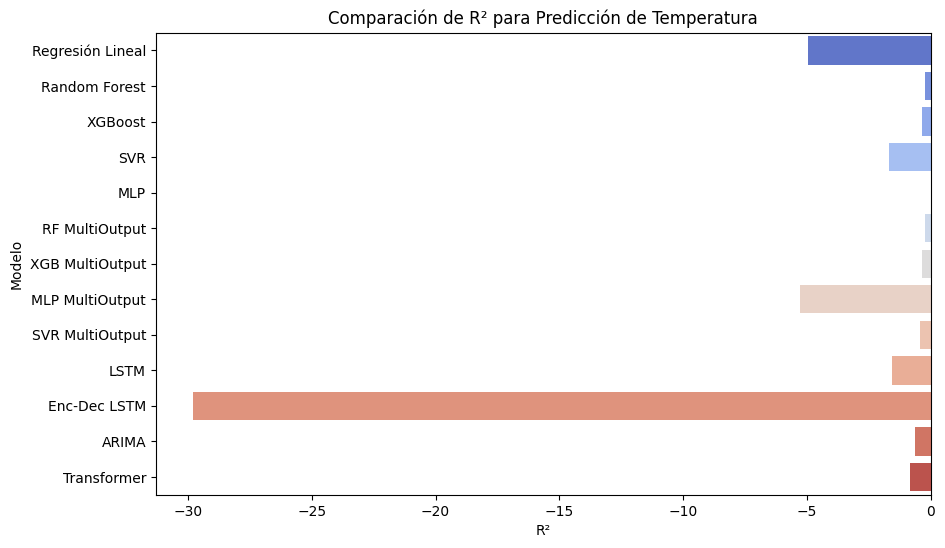

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Datos combinados de modelos que predicen temperatura futura
modelos_temp = {
    "Modelo": [
        "Regresión Lineal", "Random Forest", "XGBoost", "SVR", "MLP",
        "RF MultiOutput", "XGB MultiOutput", "MLP MultiOutput", "SVR MultiOutput",
        "LSTM", "Enc-Dec LSTM", "ARIMA", "Transformer"
    ],
    "MAE": [3.53, 1.70, 1.66, 2.29, 1.50,
            1.70, 1.66, 3.64, 1.76,
            1.45, 5.45, 3.12, 1.15],
    "RMSE": [4.41, 2.01, 2.11, 2.95, 1.81,
             2.01, 2.11, 4.53, 2.15,
             1.60, 5.54, 3.96, 1.36],
    "R2": [-4.97, -0.24, -0.36, -1.67, -0.01,
           -0.24, -0.36, -5.30, -0.42,
           -1.57, -29.81, -0.62, -0.85]
}
df_temp = pd.DataFrame(modelos_temp)

# Barplot MAE
plt.figure(figsize=(10, 6))
sns.barplot(data=df_temp, x="MAE", y="Modelo", palette="crest")
plt.title("Comparación de MAE para Predicción de Temperatura (temp_futuro_30)")
plt.xlabel("MAE (Error Absoluto Medio)")
plt.ylabel("Modelo")
plt.show()

# Barplot RMSE
plt.figure(figsize=(10, 6))
sns.barplot(data=df_temp, x="RMSE", y="Modelo", palette="flare")
plt.title("Comparación de RMSE para Predicción de Temperatura")
plt.xlabel("RMSE (Raíz del Error Cuadrático Medio)")
plt.ylabel("Modelo")
plt.show()

# Barplot R²
plt.figure(figsize=(10, 6))
sns.barplot(data=df_temp, x="R2", y="Modelo", palette="coolwarm")
plt.title("Comparación de R² para Predicción de Temperatura")
plt.xlabel("R²")
plt.ylabel("Modelo")
plt.show()


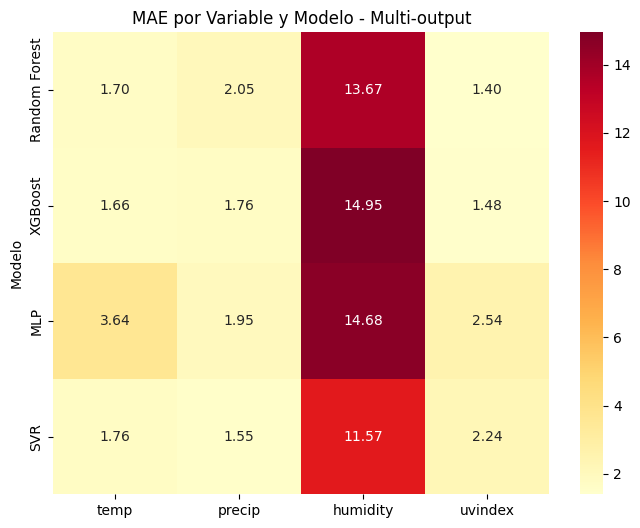

In [30]:
# MAE por variable para modelos multi-output
multi_mae = pd.DataFrame({
    "Modelo": ["Random Forest", "XGBoost", "MLP", "SVR"],
    "temp": [1.70, 1.66, 3.64, 1.76],
    "precip": [2.05, 1.76, 1.95, 1.55],
    "humidity": [13.67, 14.95, 14.68, 11.57],
    "uvindex": [1.40, 1.48, 2.54, 2.24]
}).set_index("Modelo")

plt.figure(figsize=(8, 6))
sns.heatmap(multi_mae, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("MAE por Variable y Modelo - Multi-output")
plt.show()


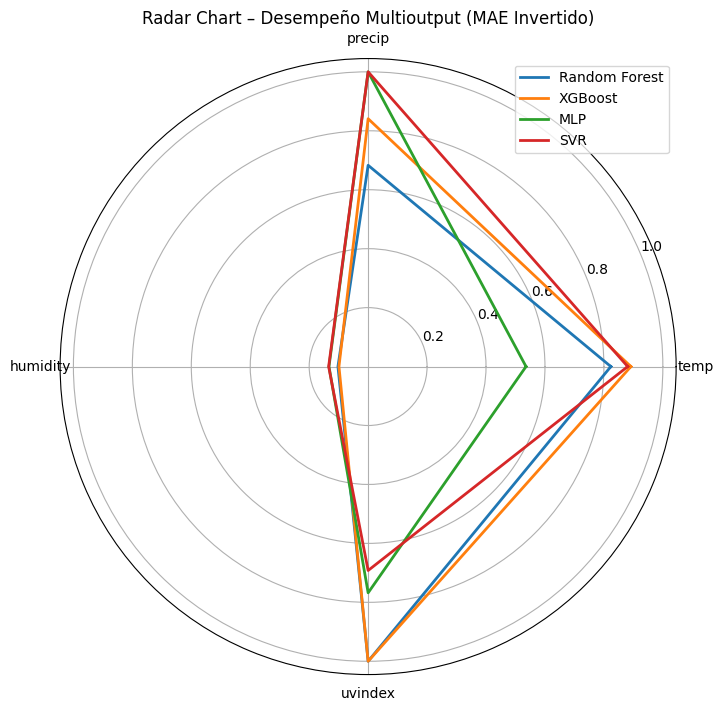

In [31]:
import numpy as np

# Datos normalizados para radar (invertimos MAE: cuanto menor, mejor)
modelos = multi_mae.index
categorias = multi_mae.columns.tolist()

valores = []
for modelo in modelos:
    row = multi_mae.loc[modelo]
    inv = 1 / (row + 1e-6)  # invertimos MAE para que mayor = mejor
    normalizado = inv / inv.max()
    valores.append(normalizado.tolist())

# Radar plot
from math import pi

num_vars = len(categorias)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

plt.figure(figsize=(8, 8))
for i, val in enumerate(valores):
    val += val[:1]  # cerrar el gráfico
    plt.polar(angles, val, label=modelos[i], linewidth=2)

plt.xticks(angles[:-1], categorias)
plt.title("Radar Chart – Desempeño Multioutput (MAE Invertido)")
plt.legend(loc='upper right')
plt.show()


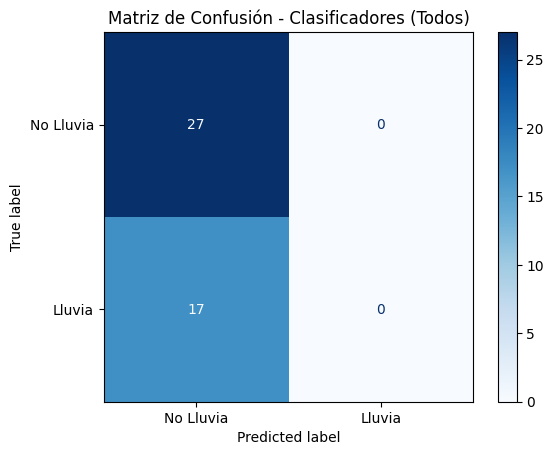

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Matriz de confusión para los 4 clasificadores
conf_matrix = np.array([[27, 0],
                        [17, 0]])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["No Lluvia", "Lluvia"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Clasificadores (Todos)")
plt.show()


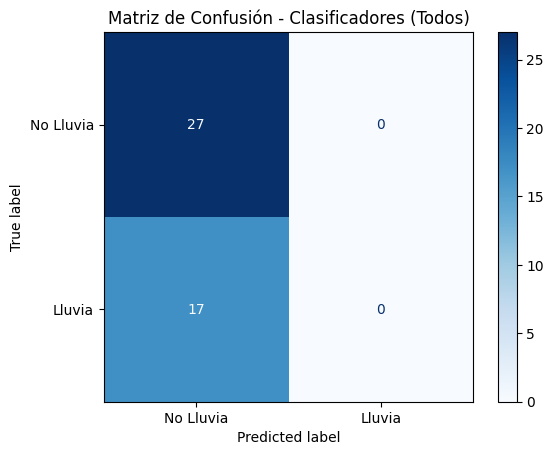

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Matriz de confusión para los 4 clasificadores
conf_matrix = np.array([[27, 0],
                        [17, 0]])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["No Lluvia", "Lluvia"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Clasificadores (Todos)")
plt.show()


## 4. Guardar modelos ya entrenados

In [39]:
from sklearn.ensemble import RandomForestRegressor
import joblib

# Lista de variables que quieres predecir
targets = ['temp_futuro_30', 'precip_futuro_30', 'humidity_futuro_30', 'uvindex_futuro_30']

# Entrenar y guardar un modelo por variable
for target in targets:
    print(f"Entrenando modelo para: {target}")
    
    modelo = RandomForestRegressor(n_estimators=30, max_depth=4, random_state=42)
    modelo.fit(X_train_scaled, df_train[target])  # Asegúrate de tener X_train_scaled y df_train preparados

    nombre_fichero = f"rf_{target}.pkl"
    joblib.dump(modelo, nombre_fichero)
    print(f"✅ Modelo guardado: {nombre_fichero}")


Entrenando modelo para: temp_futuro_30
✅ Modelo guardado: rf_temp_futuro_30.pkl
Entrenando modelo para: precip_futuro_30
✅ Modelo guardado: rf_precip_futuro_30.pkl
Entrenando modelo para: humidity_futuro_30
✅ Modelo guardado: rf_humidity_futuro_30.pkl
Entrenando modelo para: uvindex_futuro_30
✅ Modelo guardado: rf_uvindex_futuro_30.pkl


In [34]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
import joblib

# Targets a predecir con SVR
targets_svr = ['precip_futuro_30', 'humidity_futuro_30']

# Entrenar modelo multi-output
svr_base = SVR(C=1.0, epsilon=0.1)
svr_model = MultiOutputRegressor(svr_base)
svr_model.fit(X_train_scaled, df_train[targets_svr])

# Guardar modelo
joblib.dump(svr_model, "svr_multi.pkl")
print("✅ Modelo SVR MultiOutput guardado como svr_multi.pkl")


✅ Modelo SVR MultiOutput guardado como svr_multi.pkl


In [35]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# Targets a predecir con Random Forest
targets_rf = ['temp_futuro_30', 'precip_futuro_30', 'humidity_futuro_30', 'uvindex_futuro_30']

# Crear modelo Random Forest multi-output
rf_base = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model = MultiOutputRegressor(rf_base)
rf_model.fit(X_train_scaled, df_train[targets_rf])

# Guardar modelo entrenado
joblib.dump(rf_model, "rf_multi.pkl")
print("✅ Modelo Random Forest MultiOutput guardado como rf_multi.pkl")


✅ Modelo Random Forest MultiOutput guardado como rf_multi.pkl


In [36]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [37]:
def predecir_dia(input_dict):
    scaler = joblib.load("scaler.pkl")
    model = joblib.load("rf_multi.pkl")
    
    X = pd.DataFrame([input_dict])  # input_dict es un diccionario con los datos del día
    X_scaled = scaler.transform(X)
    y_pred = model.predict(X_scaled)
    
    return y_pred

In [38]:
# Exportar el dataframe ya procesado con todas las columnas necesarias para predecir
ruta_salida = "data/valencia_clima_unificado_procesado.csv"
df.to_csv(ruta_salida, index=False)
print(f"✅ CSV guardado en {ruta_salida}")


OSError: Cannot save file into a non-existent directory: 'data'